In [3]:
# Basic Libs
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
from tqdm import tqdm, tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print("CWD is ", os.getcwd())



CWD is  d:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB


In [4]:
# Vis Libs
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

In [5]:
# Text Libs
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess 
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.stem.porter import *
import nltk

# 1. Business Problem and Use of Machine Learning

## 1.1 Business Problem Description

Mercari is an Online Selling App. Sellers upload used/refurbished products on the store that they want to sell. When they upload the product on the Mercari App, they may want to know how much price they should be selling at. This helps the sellers in Pricing/Valuating their products before actually selling it. Sellers upload Product Information like Item Name (text format), Item Description (text format), Item Brand, Item Category, Item Condition, Shipping Status. When they upload these product information on the Mercari App, they in return get back the Recommended Price that would be sold at. The goal in this case study is to predict this price of a product listing given the product attributes.

## 2. Use of Machine Learning

Each row in the data represents an Item listing. The features of the Item include:

1, train_id/test_id

2, item_name (text)

3, item_description (text)

4, item_condition_id (ordinal)

5, shipping (boolean)

6, brand_name (categorical)

7, category_name (categorical)

Given these attributes, the objective is to preidct the price (numeric) of the product. This is a Regression Modelling Task.

## 1.3 Evaluation Metric

RMSLE (Root Mean Squared Logarithmic Error)
The RMSLE is calculated as
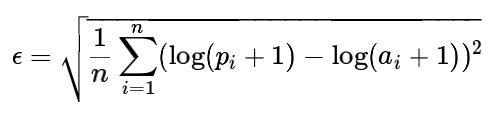

Where:

$\epsilon$ is the RMSLE value (score)

n is the total number of observations in the (public/private) data set,

$p_i$ is your prediction of price, 

$a_i$ is the actual sale price for i

$log{x}$ is the natural logarithm of x


# 2. EDA

## 2.1 Load Data

In [6]:
df_train = pd.read_csv(r"D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\mercari-price-suggestion-challenge-dataset\train.tsv\train.tsv", sep="\t")
print(df_train.shape, "\n")
df_train


(1482535, 8) 



,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


There are a total of 1.4M listings. Each row represents a product listing made by a seller: "name" , "item-condition", "category", "brand", "ship-status", "item-description" of the listing, and gets back the price (to be predicted).

We have 8 features in our dataset in which price is our target variable.

The target variable have a continious values which means It's a regression machine learning model.

Train-id: id of the product (numerical)

Name: the title of the listing.(textual)

item_condition_id - the condition of the items provided by the seller (numerical)

category_name - category of the listing(categorical)

brand_name - brand of the product (categorical)

price - the price that the item was sold for. (target)

shipping - 1 if shipping fee is paid by seller and 0 by buyer(binary)

item_description - the full description of the item.(textual)

In [7]:
df_train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [8]:
print("Number of Nan values in category_name: {}%".format((df_train['category_name'].isnull().sum()/df_train.shape[0])*100))
print("Number of Nan values in brand_name: {}%".format((df_train['brand_name'].isnull().sum()/df_train.shape[0])*100))
print("Number of Nan values in item_description: {}%".format((df_train['item_description'].isnull().sum()/df_train.shape[0])*100))
     

Number of Nan values in category_name: 0.42676901388500105%
Number of Nan values in brand_name: 42.675687251902986%
Number of Nan values in item_description: 0.0002698081326916397%


## 2.2 EDA - Price (target variable)

In [9]:
# Check NaN in "price" column
missing_values_price = df_train["price"].isnull().sum()
print("Missing values counted in Price =", missing_values_price)

# DataFrame"s description
df_description = df_train.describe().round(2)
print(df_description)

Missing values counted in Price = 0
         train_id  item_condition_id       price    shipping
count  1482535.00         1482535.00  1482535.00  1482535.00
mean    741267.00               1.91       26.74        0.45
std     427971.14               0.90       38.59        0.50
min          0.00               1.00        0.00        0.00
25%     370633.50               1.00       10.00        0.00
50%     741267.00               2.00       17.00        0.00
75%    1111900.50               3.00       29.00        1.00
max    1482534.00               5.00     2009.00        1.00


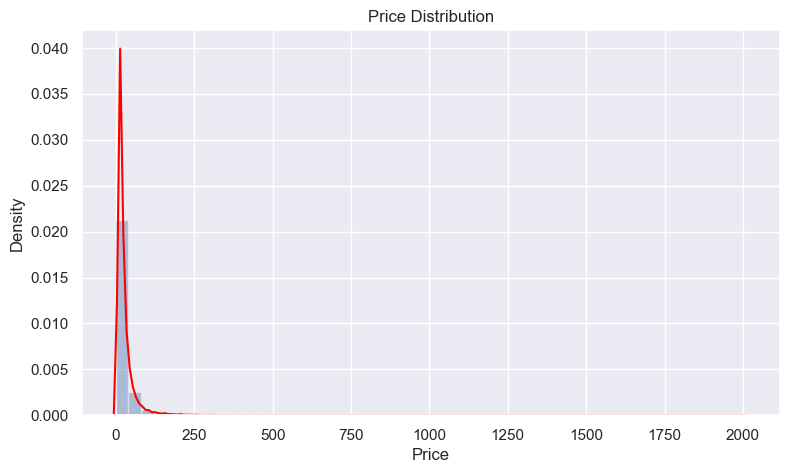

In [10]:
sns.set(rc={"figure.figsize":(9, 5)})
sns.distplot(df_train["price"], kde_kws = {"color": "red"})
plt.xlabel("Price")
plt.title("Price Distribution")
plt.show()

This distribution plot above does not give an accurate representation of the Prices.

In [11]:
def generate_percentiles(data, col, start, end, step, method):
    """generates percentiles of a numeric distribution"""
    x = PrettyTable()
    x.field_names = ["Percentile", str(col)]

    percentiles = []
    out = []
    lst = range(start, end, step) if method == "range" else np.linspace(start, end, step)
    for i in lst:
        x.add_row([i, np.round(np.percentile(data, i), 3)])
        percentiles.append(i)
        out.append(np.round(np.percentile(data, i), 3))
    print(x)
    plt.plot(percentiles, out)
    plt.title(str(col) + " Percentiles = " + str(start) + "-" + str(end-1)) if method == "range" else plt.title(str(col) + "Percentiles = " + str(start) + "-" + str(end))
    plt.show()

+------------+--------+
| Percentile | PRICE  |
+------------+--------+
|     0      |  0.0   |
|     5      |  6.0   |
|     10     |  7.0   |
|     15     |  9.0   |
|     20     |  10.0  |
|     25     |  10.0  |
|     30     |  12.0  |
|     35     |  13.0  |
|     40     |  14.0  |
|     45     |  16.0  |
|     50     |  17.0  |
|     55     |  19.0  |
|     60     |  20.0  |
|     65     |  24.0  |
|     70     |  26.0  |
|     75     |  29.0  |
|     80     |  34.0  |
|     85     |  40.0  |
|     90     |  51.0  |
|     95     |  75.0  |
|    100     | 2009.0 |
+------------+--------+


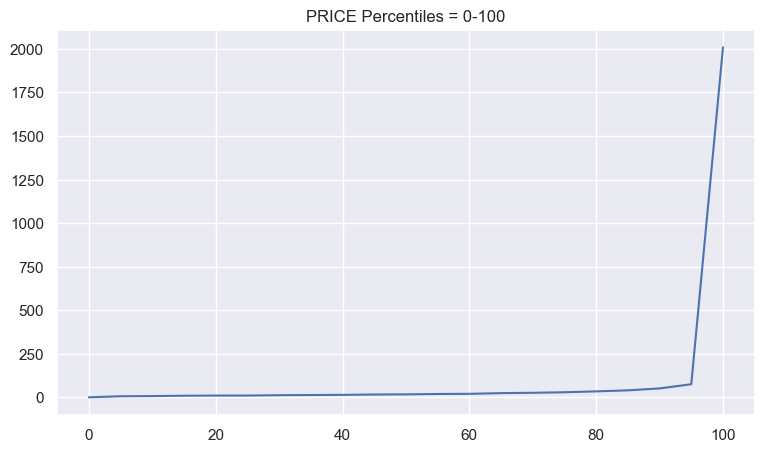

In [12]:
generate_percentiles(df_train["price"], "PRICE", 0, 101, 5, "range")

We observe a steep point of inflection after 90 percentile as per plot above -> We can deep dive and look at narrower percentile ranges like 95 - 100, 99 - 100 etc. to understand the inflection point better.

+------------+--------+
| Percentile | PRICE  |
+------------+--------+
|     95     |  75.0  |
|     96     |  85.0  |
|     97     |  99.0  |
|     98     | 122.0  |
|     99     | 170.0  |
|    100     | 2009.0 |
+------------+--------+


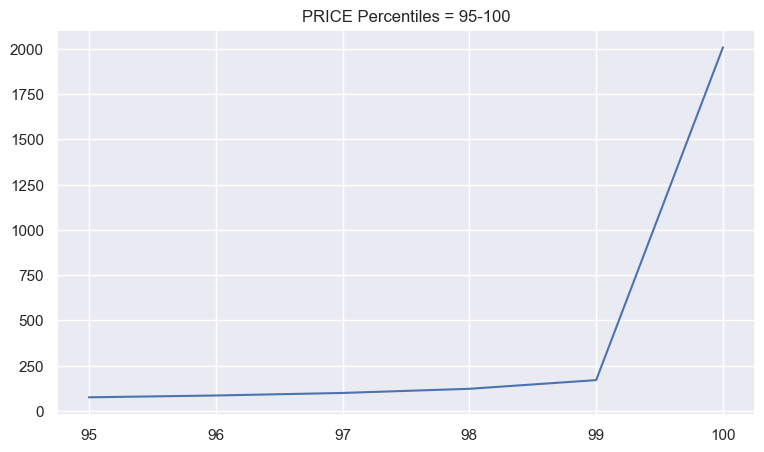

In [13]:
"""Generating Percentiles with 1 percentile increments from 95 - 100 """

generate_percentiles(df_train["price"],"PRICE", 95, 101, 1, "range")

Clearly Inflection here occurs after 99 percentile, We can deep dive further

+------------+--------+
| Percentile | PRICE  |
+------------+--------+
|    99.0    | 170.0  |
|    99.1    | 180.0  |
|    99.2    | 189.0  |
|    99.3    | 200.0  |
|    99.4    | 210.0  |
|    99.5    | 230.33 |
|    99.6    | 256.0  |
|    99.7    | 286.0  |
|    99.8    | 340.0  |
|    99.9    | 450.0  |
|   100.0    | 2009.0 |
+------------+--------+


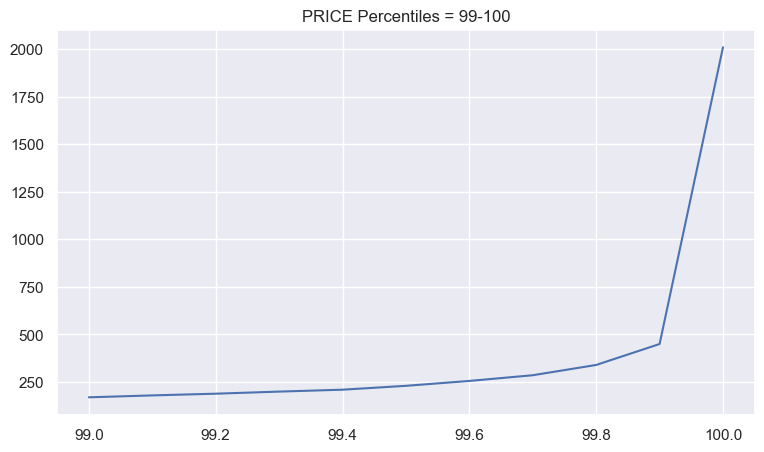

In [14]:
"""Generating Percentiles with 0.1 percentile increments from 99 - 100 """

generate_percentiles(df_train["price"], "PRICE ", 99, 100, 11, "linspace")

Even at 99.8 percentile, the price values are still below 500.

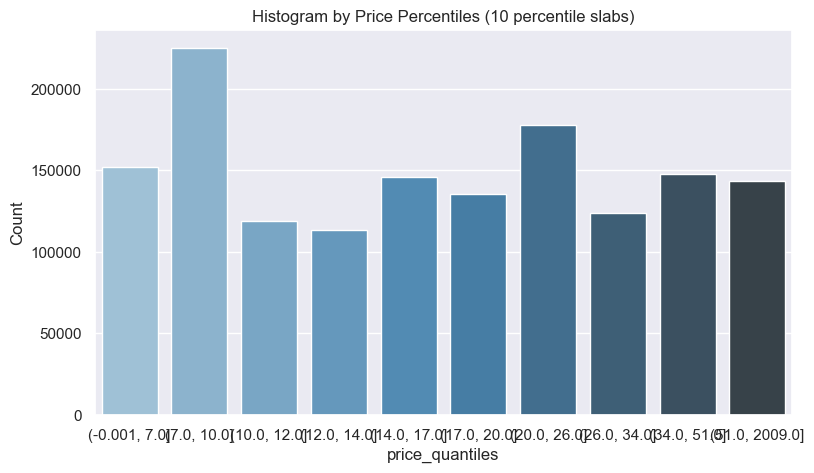

In [15]:
# Creates 10 percentile buckets for the "Price" column

df_train["price_quantiles"] = pd.qcut(df_train["price"], q=np.arange(0, 1.1, 0.1))
tmp_df = pd.DataFrame(df_train.groupby("price_quantiles").agg("size").reset_index())  # Size of each bucket_index
tmp_df.columns = ["price_quantiles", "Count"]

sns.set(rc={"figure.figsize":(9, 5)})
sns.barplot(x="price_quantiles", y="Count", data=tmp_df, palette="Blues_d")
plt.title("Histogram by Price Percentiles (10 percentile slabs)")
plt.show()

Most of the prices fall in the range of (7-10). Each Price Bucket has at least 100,000 Item Listings. Quite evenly Distributed.

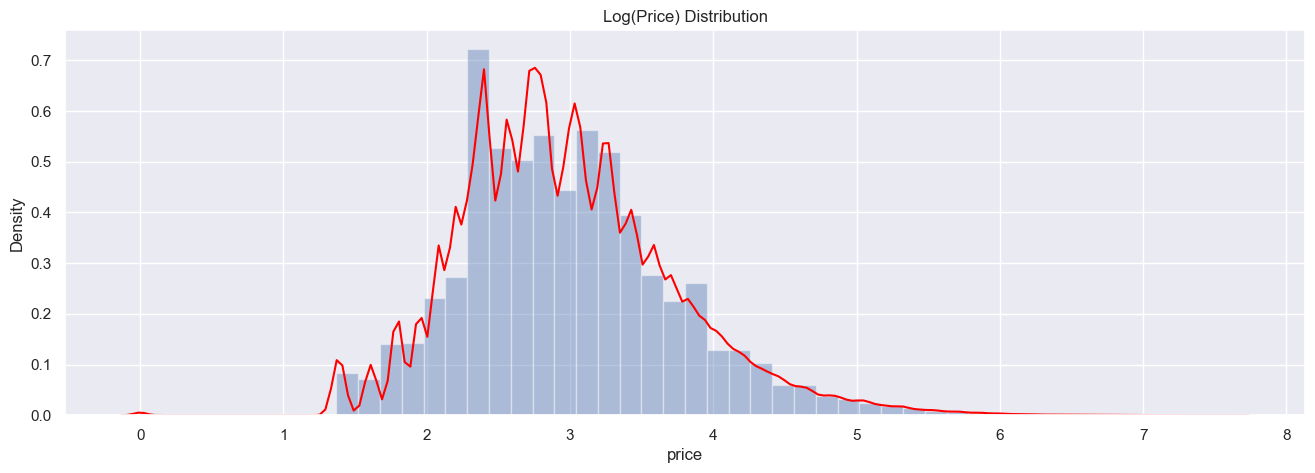

In [16]:
# Transforms the price into Log Distribution -> log(1+price)
df_train["log_price"] = np.log1p(df_train["price"])
sns.set(rc={"figure.figsize":(16, 5)})
sns.distplot(np.log1p(df_train["price"]), kde_kws = {"color": "red"})
plt.title("Log(Price) Distribution")
plt.show()


The graph looks much better now. We have a rough approximation of Log Normal Distribution of Prices.

## 2.3 EDA - Price variations in Shipping

In [17]:
print("Check missing value in Shipping Column = ", df_train.shipping.isnull().sum())
df_train.groupby("shipping")["price"].describe()


Check missing value in Shipping Column =  0


,count,mean,std,min,25%,50%,75%,max
shipping,,,,,,,,
0,819435.0,30.111778,39.53592,0.0,13.0,20.0,33.0,2009.0
1,663100.0,22.567726,36.95579,0.0,8.0,14.0,25.0,2000.0


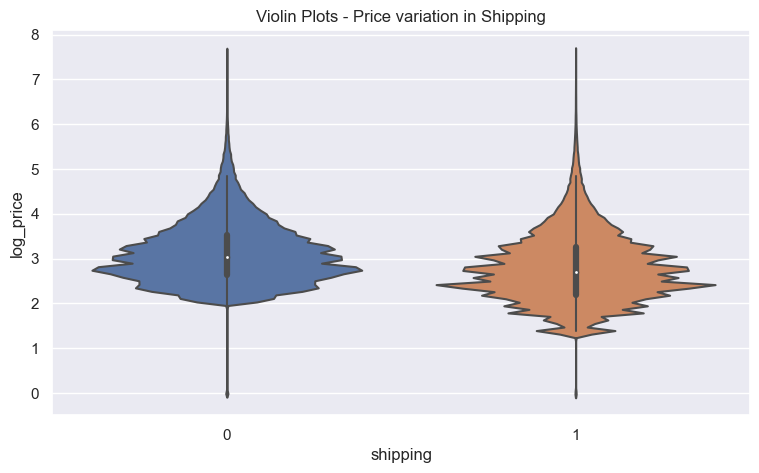

In [18]:
# generates Violin Plots of Prices by Shipping
sns.set(rc={"figure.figsize":(9, 5)})   
sns.violinplot(x="shipping", y="log_price", data=df_train)
plt.title("Violin Plots - Price variation in Shipping")
plt.show()

We can see that values for shipping = 1 are lower than for shipping = 0. Shipping = 1 indicates that the shipping price was paid by the seller.

In [19]:
# conducts a statistical significance test using One way ANOVA to see if prices in shipping differ significantly
from scipy.stats import f_oneway

stat, p = f_oneway(df_train["price"].values[df_train["shipping"] == 1], df_train.price.values[df_train.shipping == 0])
print("Statistics = %.9f, p = %.9f" % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)")
else:
    print("Different distribution (reject H0)")

Statistics = 14143.607688957, p = 0.000000000
Different distribution (reject H0)


Clearly, ANOVA test suggests that there is a significant difference and "p" value is quite negligible - so we will be going forward with our conclusion that there is indeed a significant enough difference between the 2 shipping categories in the price values.

## 2.4 EDA - Price variations in Item Condition

In [20]:
print("Check missing values in Item COndition Column = ", df_train.item_condition_id.isnull().sum())
df_train.groupby("item_condition_id")["price"].describe()

Check missing values in Item COndition Column =  0


,count,mean,std,min,25%,50%,75%,max
item_condition_id,,,,,,,,
1,640549.0,26.486967,35.418024,0.0,10.0,18.0,30.00,2009.0
2,375479.0,27.563225,42.125698,0.0,11.0,17.0,29.00,2004.0
3,432161.0,26.540711,40.030681,0.0,11.0,16.0,28.00,2000.0
4,31962.0,24.349212,35.679148,0.0,10.0,15.0,26.00,1309.0
5,2384.0,31.703859,39.531069,0.0,11.0,19.0,35.25,522.0


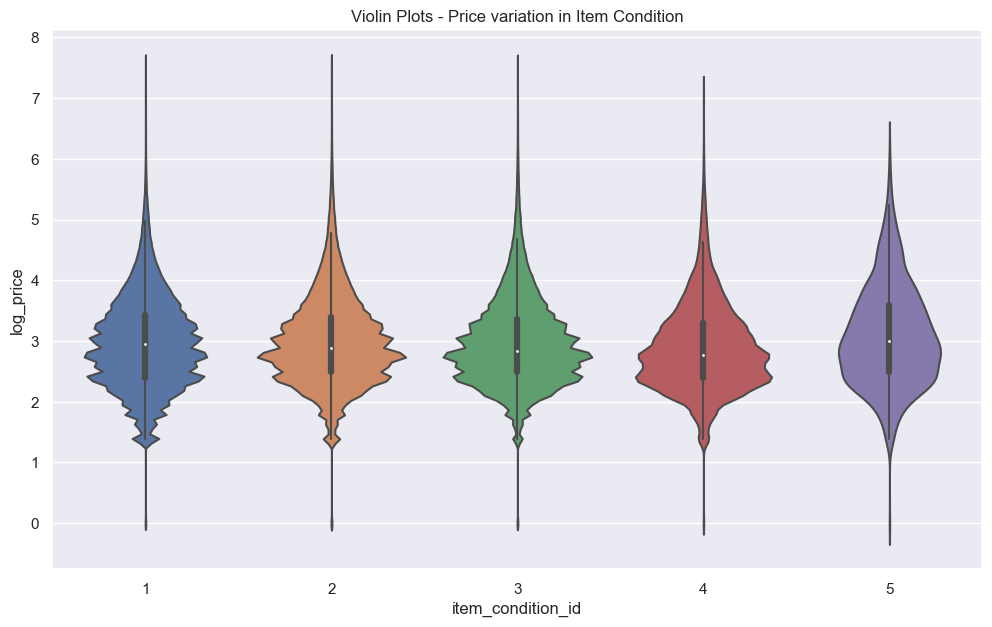

In [21]:
sns.set(rc={"figure.figsize":(12, 7)})
sns.violinplot(x="item_condition_id", y="log_price", data=df_train)
plt.title("Violin Plots - Price variation in Item Condition")
plt.show()

In [22]:
from scipy.stats import f_oneway

stat, p = f_oneway(df_train["price"].values[df_train["item_condition_id"] == 1], df_train.price.values[df_train.item_condition_id == 2], df_train.price.values[df_train.item_condition_id == 3], df_train.price.values[df_train.item_condition_id == 4], df_train.price.values[df_train.item_condition_id == 5])
print("Statistics = %.9f, p = %.9f" % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)")  
else:
    print("Different distribution (reject H0)")

Statistics = 93.055869753, p = 0.000000000
Different distribution (reject H0)


Even this difference is significant.

## 2.5 EDA - Price variations in Brands

In [23]:
print("Check missing values in Brand Column = ", df_train.brand_name.isnull().sum(), "which is",
     round(df_train.brand_name.isnull().sum()/len(df_train),4)*100," %","\n")
print("Unique Number of Brands are = ", df_train.brand_name.nunique())

Check missing values in Brand Column =  632682 which is 42.68  % 

Unique Number of Brands are =  4809


In [24]:
# groups the data by Brand Names
df_brands = pd.DataFrame(df_train.groupby("brand_name", as_index=False).agg({"price": "mean","shipping" : "count"}))
df_brands.columns = ["brand_name", "avg_price", "count"]
df_brands = df_brands.sort_values(by="count", ascending=False)
df_brands["cumsum_count"] = df_brands["count"].cumsum()
df_brands["cumsum_perc"] = round(100*(df_brands["cumsum_count"]/df_brands["count"].sum()),2)
df_brands = df_brands.reset_index()

print("df_brands.shape = ", df_brands.shape)
df_brands.head(12)

df_brands.shape =  (4809, 6)


,index,brand_name,avg_price,count,cumsum_count,cumsum_perc
0,3221,PINK,26.341314,54088,54088,6.36
1,3057,Nike,30.760265,54043,108131,12.72
2,4504,Victoria's Secret,23.214287,48036,156167,18.38
3,2604,LuLaRoe,33.667967,31024,187191,22.03
4,267,Apple,73.268618,17322,204513,24.06
5,1510,FOREVER 21,12.929935,15186,219699,25.85
6,3067,Nintendo,34.672619,15007,234706,27.62
7,2626,Lululemon,47.096717,14558,249264,29.33
8,2841,Michael Kors,62.254775,13928,263192,30.97
9,213,American Eagle,15.960955,13254,276446,32.53


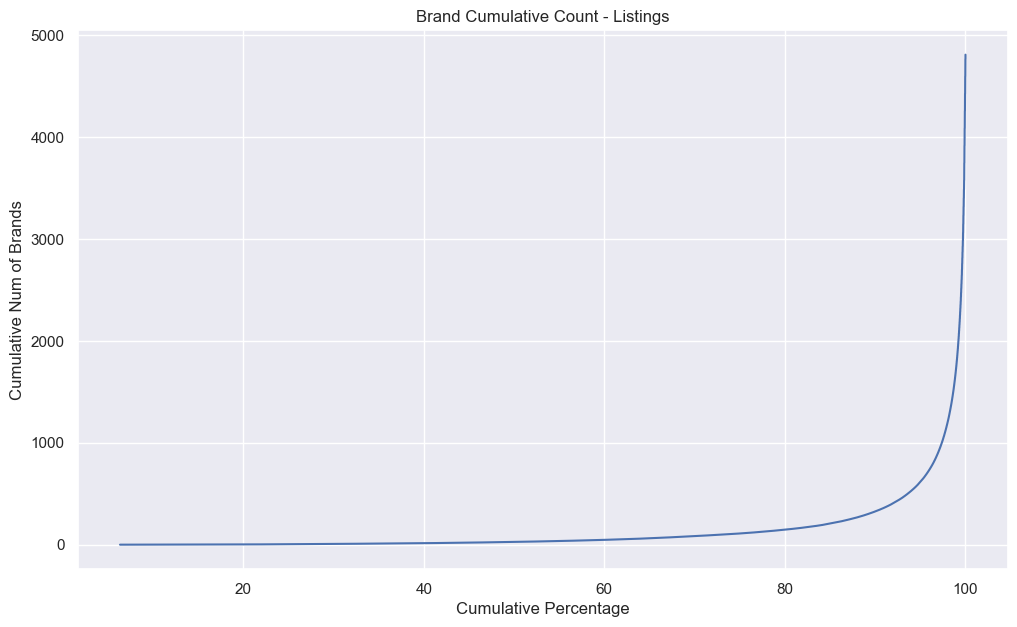

In [25]:
plt.plot(df_brands.cumsum_perc,df_brands.index)
plt.xlabel('Cumulative Percentage')
plt.ylabel('Cumulative Num of Brands')
plt.title('Brand Cumulative Count - Listings')
plt.show()

97% of Product Listings are covered by top 1000 Brands (by Count of Listings)

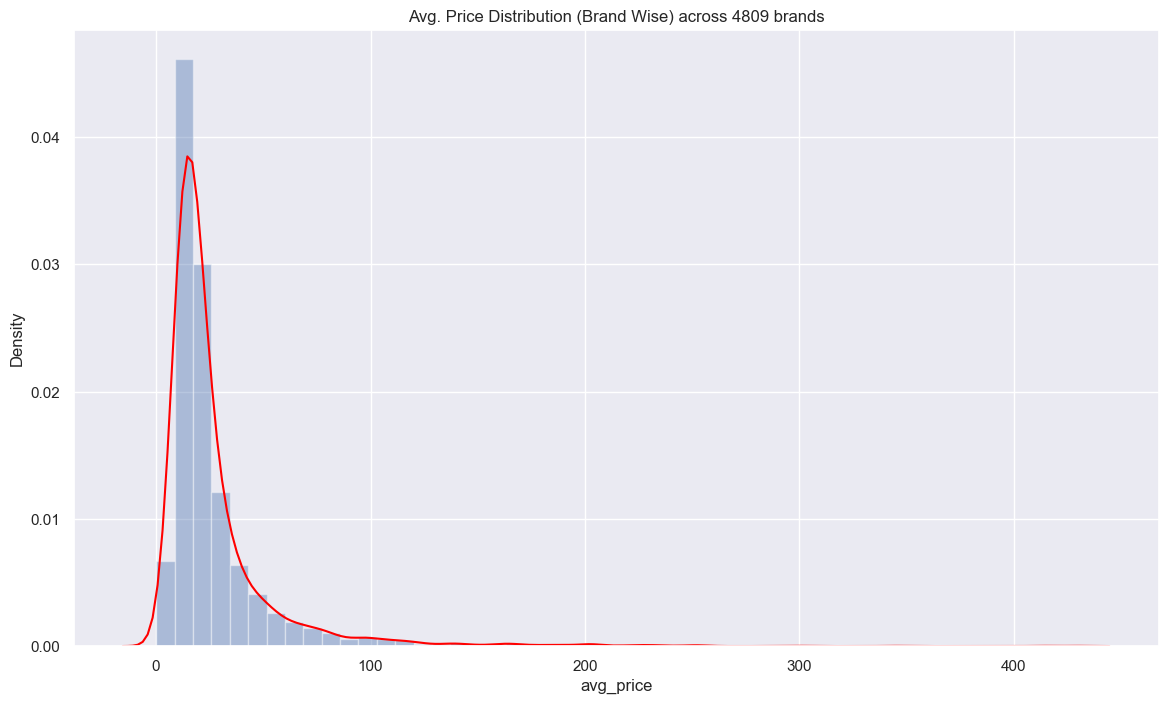

In [26]:
sns.set(rc={"figure.figsize":(14, 8)})
sns.distplot(df_brands["avg_price"], kde_kws = {"color": "red"})
plt.title("Avg. Price Distribution (Brand Wise) across " + str(len(df_brands))+" brands")
plt.show()

Most Brands have Avg Price Ranges in the Range of about = (20-30)

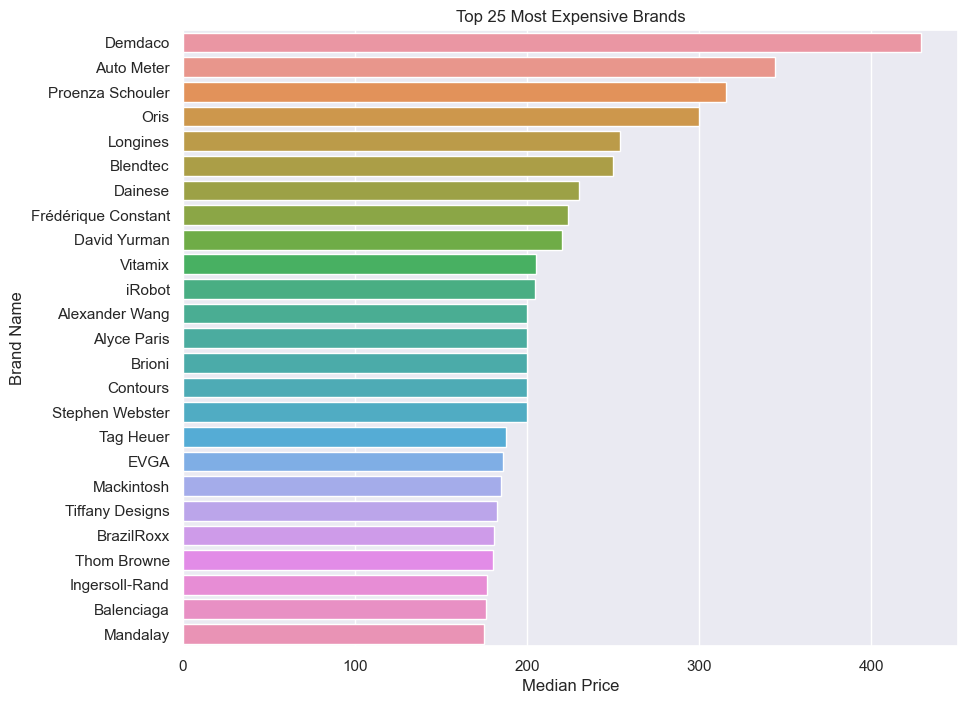

In [63]:
# Compute median price for each brand
median_prices = df_train.groupby('brand_name')['price'].median().reset_index()

# Select the top 25 brands based on median price
top_25_brands = median_prices.nlargest(25, 'price')

# Create a horizontal bar plot
sns.set(rc={"figure.figsize": (10, 8)})
sns.barplot(x='price', y='brand_name', data=top_25_brands)
plt.xlabel('Median Price')
plt.ylabel('Brand Name')
plt.title('Top 25 Most Expensive Brands')
plt.show()

The Demdaco and Auto Meter brands are by far the most expensive brands, with a median price of $400 and $320 respectively.


## 2.6 - Price variations across Categories

In [28]:
print("Check missing values in Category Column = ", df_train.category_name.isnull().sum(), " which is ",
     round(df_train.category_name.isnull().sum()/len(df_train),4)*100," %")


Check missing values in Category Column =  6327  which is  0.43  %


In [29]:
df_train["category_name"].values

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse', ...,
       'Sports & Outdoors/Exercise/Fitness accessories',
       'Home/Home Décor/Home Décor Accents',
       "Women/Women's Accessories/Wallets"], dtype=object)

As we can see, Category generally occurs in 3 Levels - seperated by the "/" delimiter . This typically represents a Product category Hierarchy in the Product Listing Catelogue. In certain listings , there are even 5 Levels

In [65]:
unique_category_count = len(df_train['category_name'].unique())
print(unique_category_count)

1288


In [30]:
# splits the category_name column into 5 differnet columns based on "/" delimiter splitter
df_train["cat1"], df_train["cat2"], df_train["cat3"], df_train["cat4"], df_train["cat5"] = df_train["category_name"].str.split("/", 4).str
df_train.head(5)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_quantiles,log_price,cat1,cat2,cat3,cat4,cat5
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,"(7.0, 10.0]",2.397895,Men,Tops,T-shirts,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,"(51.0, 2009.0]",3.970292,Electronics,Computers & Tablets,Components & Parts,NaN,NaN
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,"(7.0, 10.0]",2.397895,Women,Tops & Blouses,Blouse,NaN,NaN
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,"(34.0, 51.0]",3.583519,Home,Home Décor,Home Décor Accents,NaN,NaN
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,"(34.0, 51.0]",3.806662,Women,Jewelry,Necklaces,NaN,NaN


In [66]:
top_10_categories = df_train['category_name'].value_counts().sort_values(ascending=False).head(10)
print(top_10_categories)

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Blouse                                    20284
Women/Tops & Blouses/Tank, Cami                                20284
Name: category_name, dtype: int64


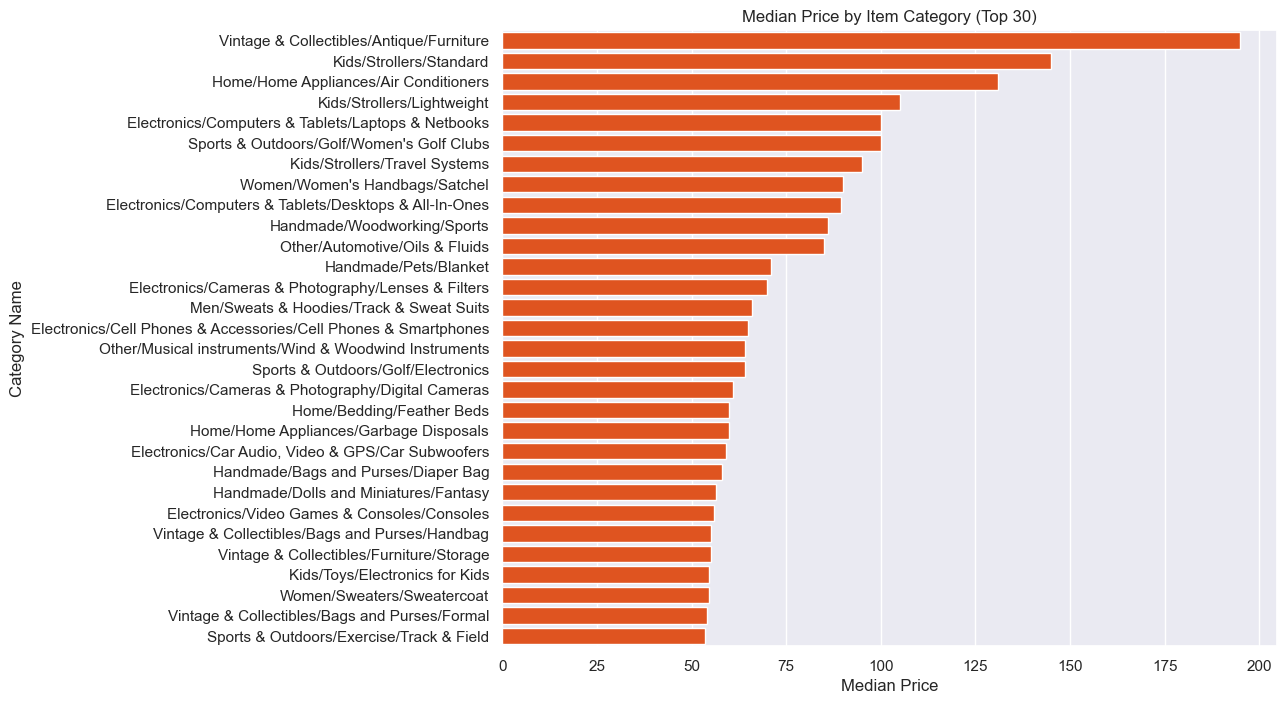

In [67]:
# Compute median price for each item category
median_prices_by_category = df_train.groupby('category_name')['price'].median().reset_index()

# Select the top 30 categories based on median price
top_30_categories = median_prices_by_category.nlargest(30, 'price')

# Create a horizontal bar plot
sns.set(rc={"figure.figsize": (10, 8)})
sns.barplot(x='price', y='category_name', data=top_30_categories, color='orangered')
plt.xlabel('Median Price')
plt.ylabel('Category Name')
plt.title('Median Price by Item Category (Top 30)')
plt.show()

### Category 1

In [31]:
print("Checking missing values in Cat1 column =", df_train.cat1.isnull().sum(), " which is ",
    round(df_train.cat1.isnull().sum()/len(df_train),4)*100," %","\n")
print("Unique Number of Elements in Cat1 are = ", df_train.cat1.nunique())
print("Elements in Cat1 are = ", df_train.cat1.unique())

Checking missing values in Cat1 column = 6327  which is  0.43  % 

Unique Number of Elements in Cat1 are =  10
Elements in Cat1 are =  ['Men' 'Electronics' 'Women' 'Home' 'Sports & Outdoors'
 'Vintage & Collectibles' 'Beauty' 'Other' 'Kids' nan 'Handmade']


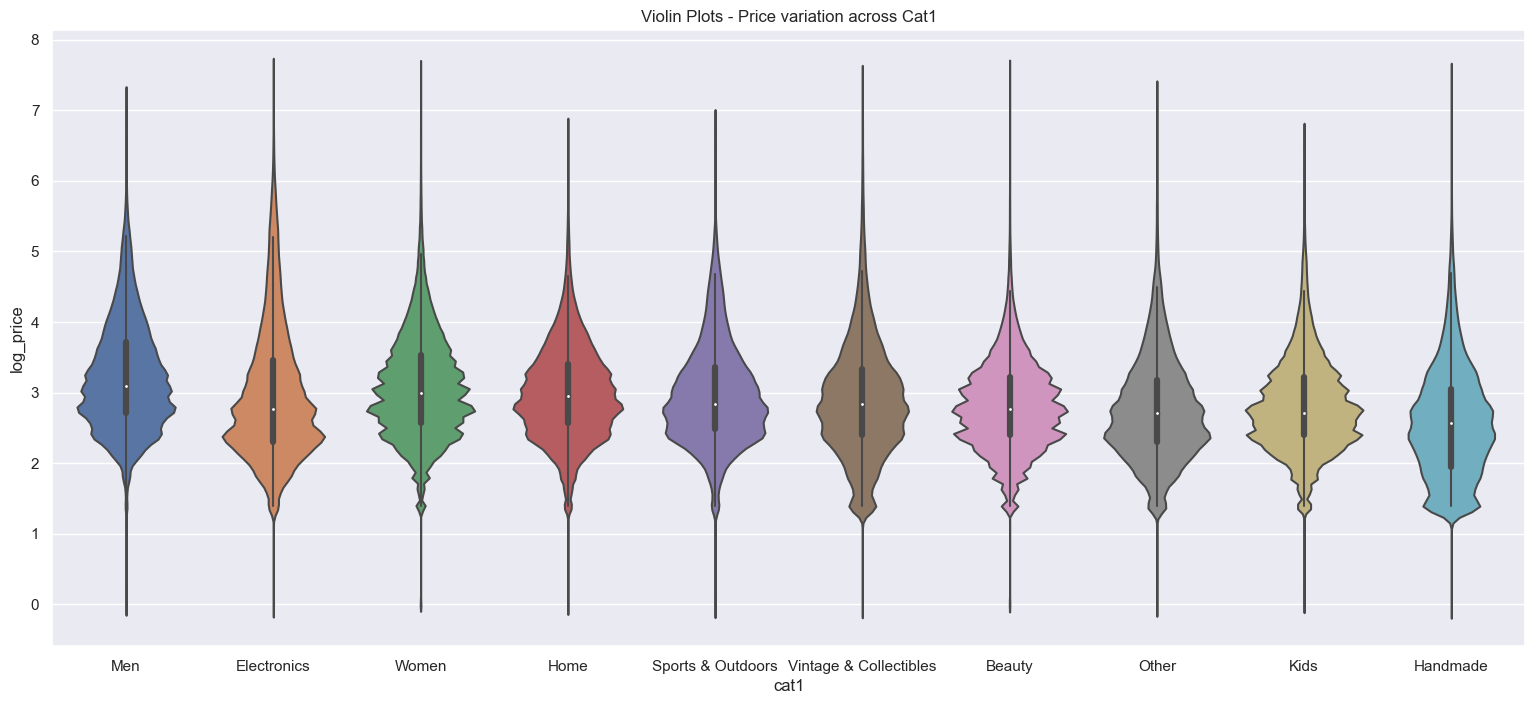

In [32]:
sns.set(rc={"figure.figsize":(19, 8)})
sns.violinplot(x="cat1", y="log_price", data=df_train)
plt.title("Violin Plots - Price variation across Cat1")
plt.show()

Men Categories have highest Median Price whereas Handmade categories have lowest median price. These prices are significant because we are looking at log scale here.

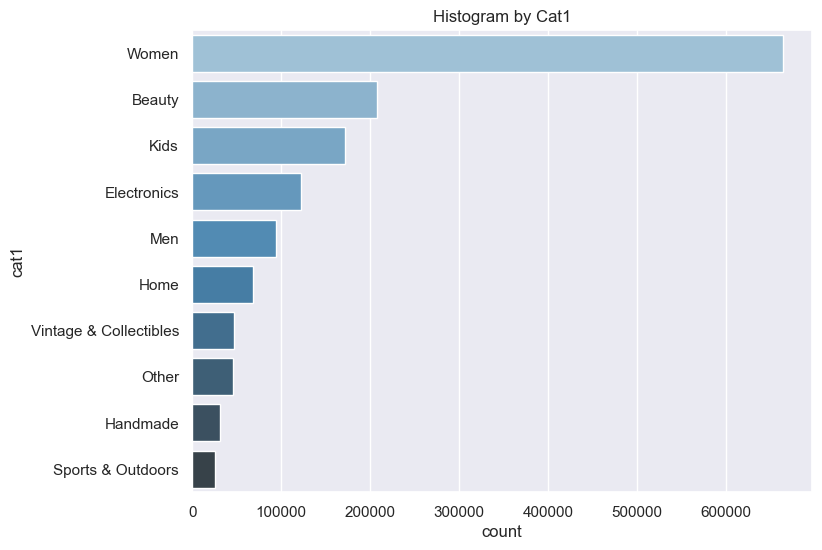

In [33]:
df1_cat1_counts = pd.DataFrame(df_train.groupby(["cat1"],as_index = False).agg({"shipping" : "count"}))
df1_cat1_counts.columns = ["cat1", "count"]
df1_cat1_counts = df1_cat1_counts.sort_values(by="count", ascending=False)

sns.set(rc={"figure.figsize":(8, 6)})
sns.barplot(x="count", y="cat1", data=df1_cat1_counts, palette="Blues_d")
plt.title("Histogram by Cat1")
plt.show()
    


Most of the Item Categories belong to "women category" - Level 1

In [34]:
# concatenates the cat1,cat2,cat3 texts
text_cat3 = " ".join(cat for cat in df_train["cat3"].values.astype(str))
text_cat2 = " ".join(cat for cat in df_train["cat2"].values.astype(str))
text_cat1 = " ".join(cat for cat in df_train["cat1"].values.astype(str))

text_cat = text_cat1 + " " + text_cat2 + " " + text_cat3
print("There are {} words in the combination of all review.".format(len(text_cat)))

There are 45937419 words in the combination of all review.


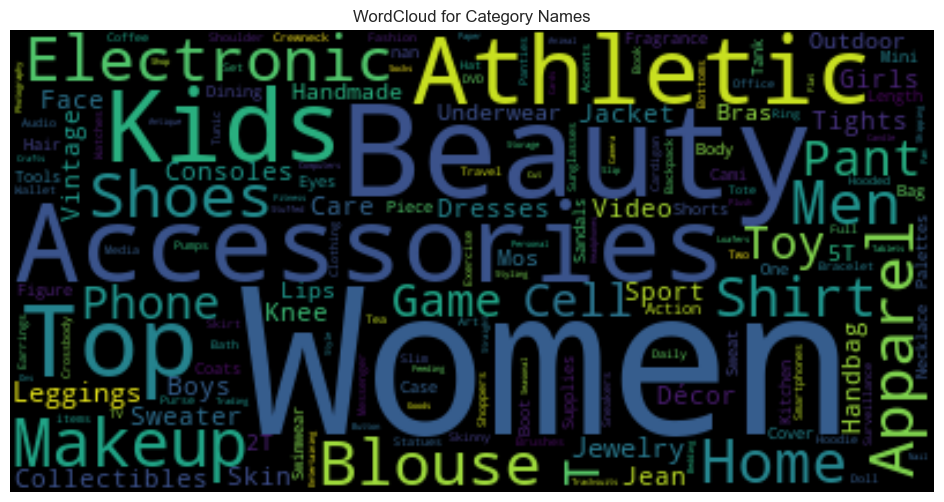

In [35]:
# generates wordclouds
wordcloud = WordCloud(collocations=False).generate(text_cat)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Category Names")
plt.show()

Most of the Words in the "category_name" contain "Beauty", "Women" "Accessories" - This is evident since most of the categories belong to Women Category (Level 1) - cat1

### Category 2

In [36]:
print("Checking missing values in Cat2 column =", df_train.cat2.isnull().sum(), " which is ",
    round(df_train.cat2.isnull().sum()/len(df_train),4)*100," %","\n")
print("Unique Number of Elements in Cat2 are = ", df_train.cat2.nunique())
print("Elements in Cat2 are = ", df_train.cat2.unique())

Checking missing values in Cat2 column = 6327  which is  0.43  % 

Unique Number of Elements in Cat2 are =  113
Elements in Cat2 are =  ['Tops' 'Computers & Tablets' 'Tops & Blouses' 'Home Décor' 'Jewelry'
 'Other' 'Swimwear' 'Apparel' 'Collectibles' 'Makeup' 'Fragrance'
 'Dresses' 'Office supplies' 'Shoes' 'Gear' 'Athletic Apparel'
 'Cell Phones & Accessories' 'Jeans' 'Underwear' 'Skin Care' 'Toys'
 "Women's Handbags" 'Video Games & Consoles' 'Coats & Jackets' 'Pants'
 'Girls (4+)' 'Antique' 'Kitchen & Dining' 'Sweaters' 'Boys 0-24 Mos'
 'Girls 0-24 Mos' 'Maternity' 'Bedding' 'Exercise' 'Trading Cards'
 'Boys (4+)' 'Storage & Organization' 'Fan Shop' 'Girls 2T-5T'
 "Men's Accessories" 'Boys 2T-5T' "Women's Accessories"
 'Daily & Travel items' nan 'Skirts' 'Hair Care' 'Pet Supplies' 'Book'
 'Tools & Accessories' 'Team Sports' 'Home Appliances' 'Accessories'
 'Bags and Purses' 'Sweats & Hoodies' 'Shorts' 'TV, Audio & Surveillance'
 'Outdoors' 'Bath & Body' 'Car Seats & Accessories' 'Toy

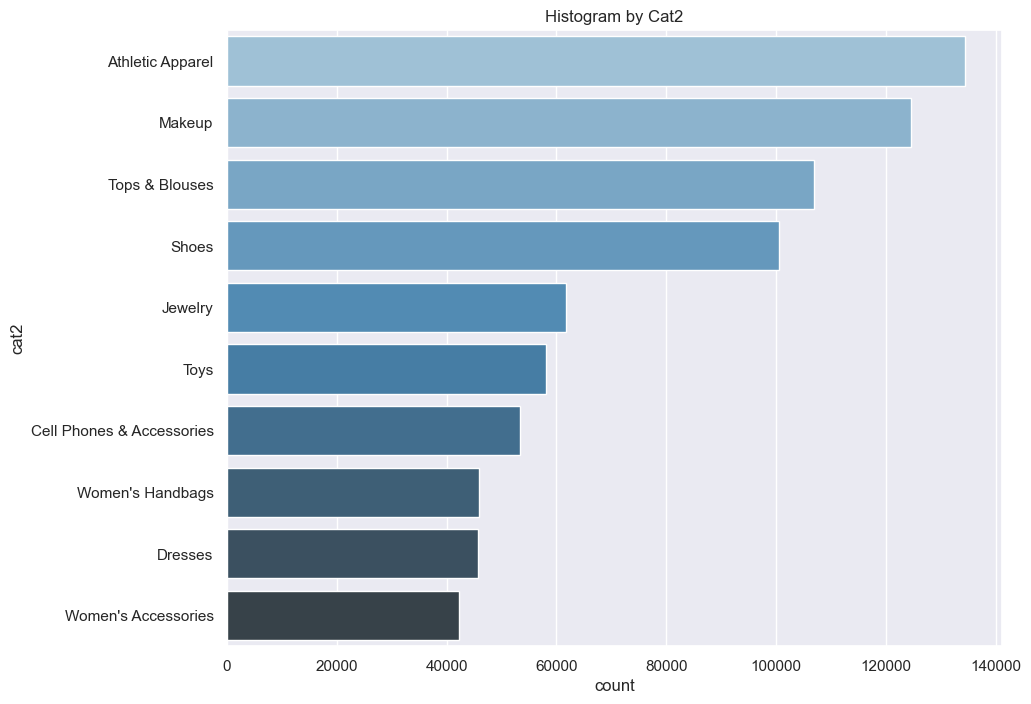

In [37]:
df1_cat2_counts = pd.DataFrame(df_train.groupby(["cat2"],as_index = False).agg({"shipping" : "count"}))
df1_cat2_counts.columns = ["cat2", "count"]
df1_cat2_counts = df1_cat2_counts.sort_values(by="count", ascending=False).head(10)

sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(x="count", y="cat2", data=df1_cat2_counts, palette="Blues_d")
plt.title("Histogram by Cat2")
plt.show()

### Category 3

In [38]:
print("Checking missing values in Cat3 column =", df_train.cat3.isnull().sum(), " which is ",
    round(df_train.cat3.isnull().sum()/len(df_train),4)*100," %","\n")
print("Unique Number of Elements in Cat3 are = ", df_train.cat3.nunique())
print("Elements in Cat3 are = ", df_train.cat3.unique())

Checking missing values in Cat3 column = 6327  which is  0.43  % 

Unique Number of Elements in Cat3 are =  870
Elements in Cat3 are =  ['T-shirts' 'Components & Parts' 'Blouse' 'Home Décor Accents' 'Necklaces'
 'Other' 'Two-Piece' 'Girls' 'Doll' 'Face' 'Women' 'Above Knee, Mini'
 'School Supplies' 'Boots' 'Makeup Sets' 'Eyes' 'Backpacks & Carriers'
 'Makeup Palettes' 'Tank, Cami' 'Sports Bras' 'Cell Phones & Smartphones'
 'Chargers & Cradles' 'T-Shirts' 'Athletic' 'Cases, Covers & Skins'
 'Pants, Tights, Leggings' 'One-Piece' 'Boot Cut' 'Bras'
 'Stuffed Animals & Plush' 'Totes & Shoppers' 'Shirts & Tops' 'Consoles'
 'Glass' 'Vest' 'Arts & Crafts' 'Capris, Cropped' 'Messenger & Crossbody'
 'Shoes' 'Collectibles' 'Coffee & Tea Accessories' 'Brooch' 'Headsets'
 'Rings' 'Shorts' 'Fleece Jacket' 'Dolls & Accessories' 'Crewneck'
 'Jackets' 'Home Fragrance' 'Accessories' 'Tops & Blouses'
 'Sheets & Pillowcases' 'Fitness technology' 'Dress Up & Pretend Play'
 'Animation' 'Jewelry Boxes & Orga

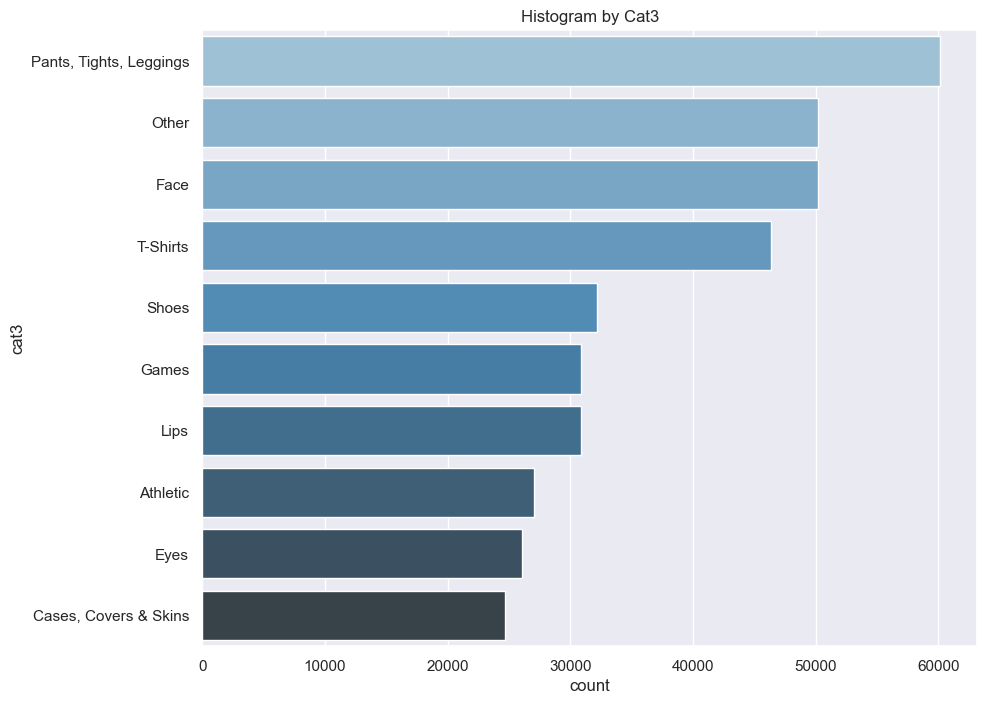

In [39]:
df1_cat3_counts = pd.DataFrame(df_train.groupby(["cat3"],as_index = False).agg({"shipping" : "count"}))
df1_cat3_counts.columns = ["cat3", "count"]
df1_cat3_counts = df1_cat3_counts.sort_values(by="count", ascending=False).head(10)

sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(x="count", y="cat3", data=df1_cat3_counts, palette="Blues_d")
plt.title("Histogram by Cat3")
plt.show()

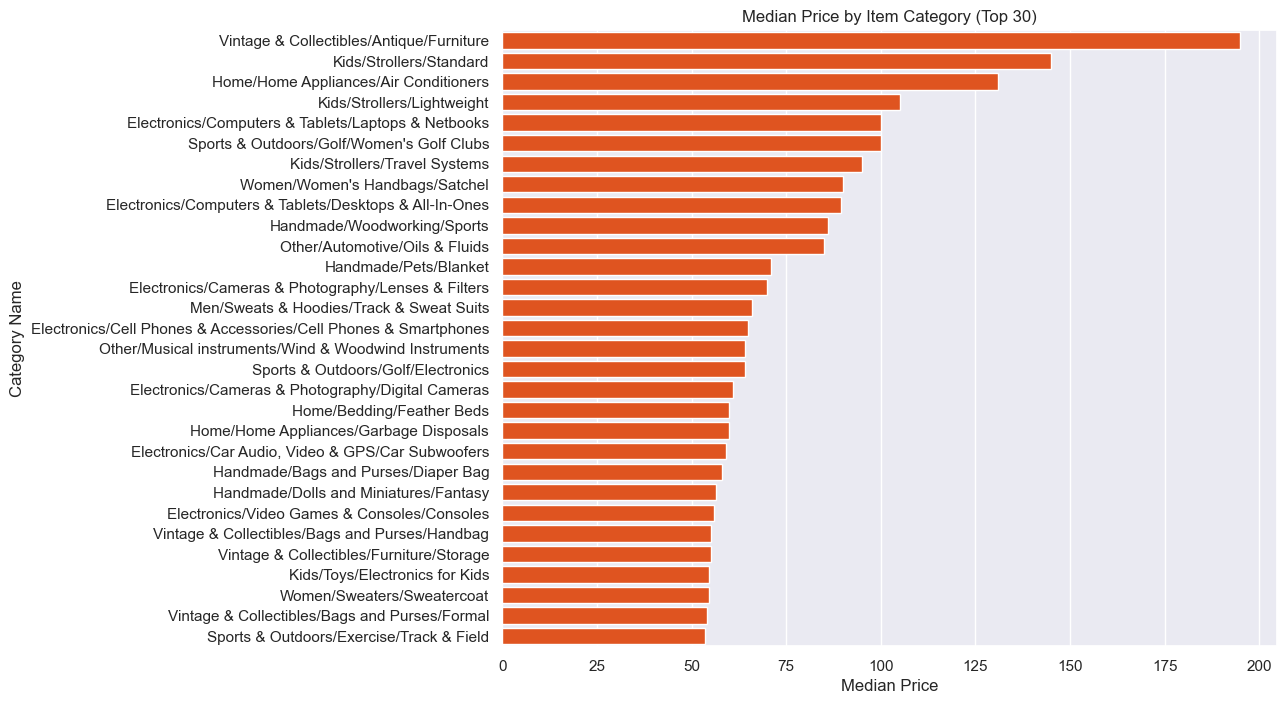

In [64]:
# Compute median price for each item category
median_prices_by_category = df_train.groupby('category_name')['price'].median().reset_index()

# Select the top 30 categories based on median price
top_30_categories = median_prices_by_category.nlargest(30, 'price')

# Create a horizontal bar plot
sns.set(rc={"figure.figsize": (10, 8)})
sns.barplot(x='price', y='category_name', data=top_30_categories, color='orangered')
plt.xlabel('Median Price')
plt.ylabel('Category Name')
plt.title('Median Price by Item Category (Top 30)')
plt.show()

## 2.7 EDA - Visualize "Item Names"

In [40]:
print("Missing values in listing 'name' are ", df_train["name"].isnull().sum())

Missing values in listing 'name' are  0


In [41]:
# performs text processing by cleaning text including 
# removing stopwords, removing special characters, performing, word decontraction etc. 

def decontracted(phrase):
    # specific 
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general 
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# removes stopwords
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"] # remove "no", "nor", "not" from stopwords list
def text_preprocess(data):
    preprocessed = []
    # use tqdm to print the status bar
    for sentence in tqdm_notebook(data):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace("\\'", " ")
        sent = sent.replace("\\n", " ")
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)

        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed



In [42]:
df_train["name_preprocessed"] = text_preprocess(df_train["name"])

  0%|          | 0/1482535 [00:00<?, ?it/s]

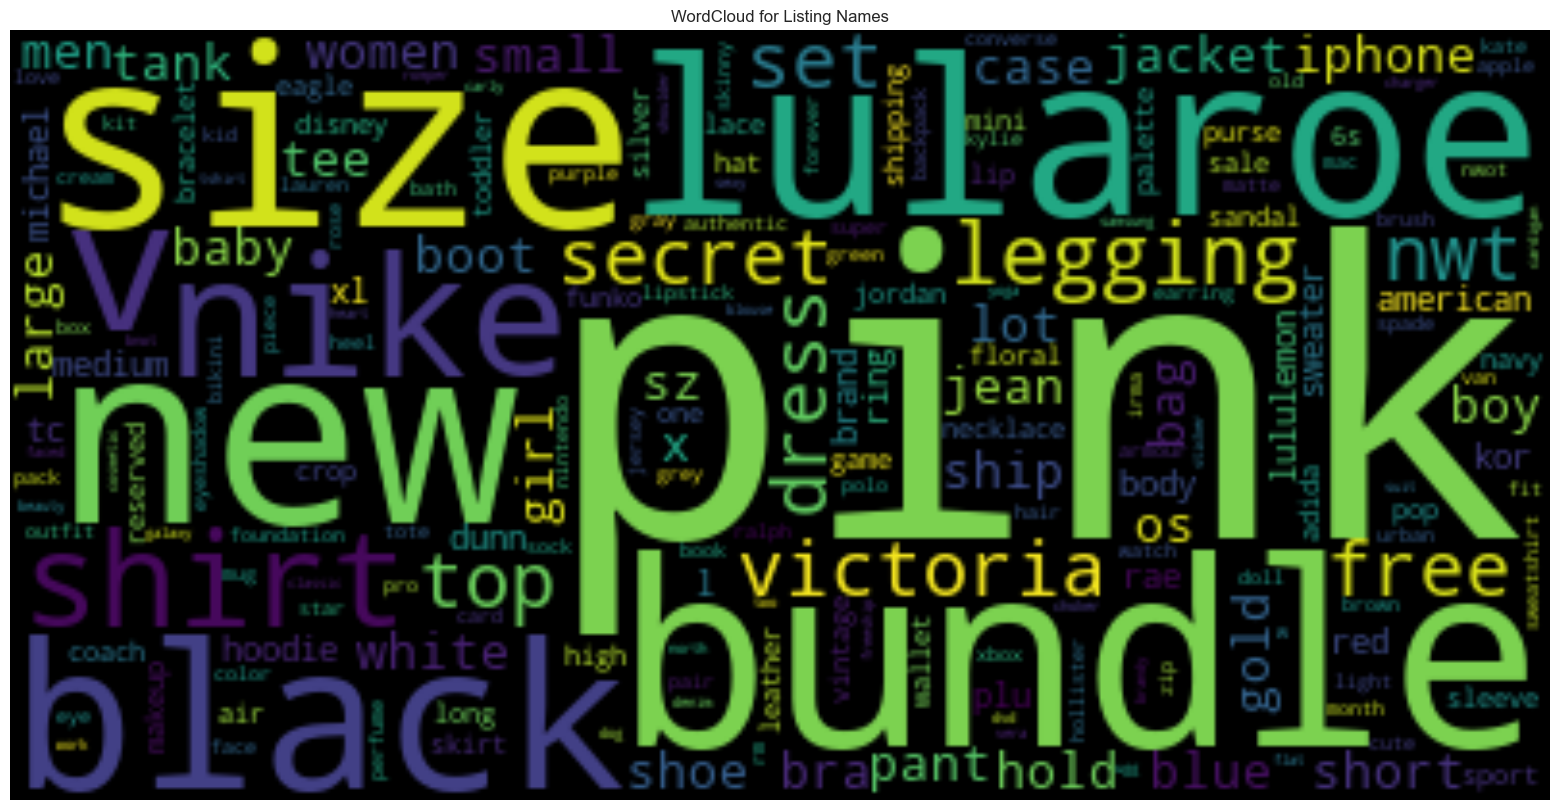

In [43]:
# generates WordCloud for Item Name column
wordcloud = WordCloud(collocations=False).generate(" ".join(df_train["name_preprocessed"]))
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Listing Names")
plt.show()


Above are the most frequently occuring words in Item Name column, we can see that item names contains lot of information related to brand of the item

In [44]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nghaphg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
# generates Word Frequency distribution dataframe
a = df_train["name_preprocessed"].str.lower().str.cat(sep=" ")

words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

df_names_freq_dist = pd.DataFrame(word_dist.most_common(),columns=['Word', 'Frequency'])
df_names_freq_dist = df_names_freq_dist.sort_values(by=['Frequency'],ascending = False)
df_names_freq_dist['cumsum_Frequency'] = df_names_freq_dist['Frequency'].cumsum()
df_names_freq_dist['cumsum_perc'] = round(100*(df_names_freq_dist['cumsum_Frequency']/df_names_freq_dist['Frequency'].sum()),2)
df_names_freq_dist = df_names_freq_dist.reset_index()
print(df_names_freq_dist.shape, ' df_names_freq_dist.shape ')
df_names_freq_dist.head(10)

(104758, 5)  df_names_freq_dist.shape 


,index,Word,Frequency,cumsum_Frequency,cumsum_perc
0,0,pink,83951,83951,1.35
1,1,bundle,77836,161787,2.59
2,2,new,76892,238679,3.83
3,3,size,73413,312092,5.00
4,4,lularoe,63445,375537,6.02
5,5,black,56399,431936,6.92
6,6,nike,46471,478407,7.67
7,7,vs,44384,522791,8.38
8,8,2,41317,564108,9.04
9,9,secret,40533,604641,9.69


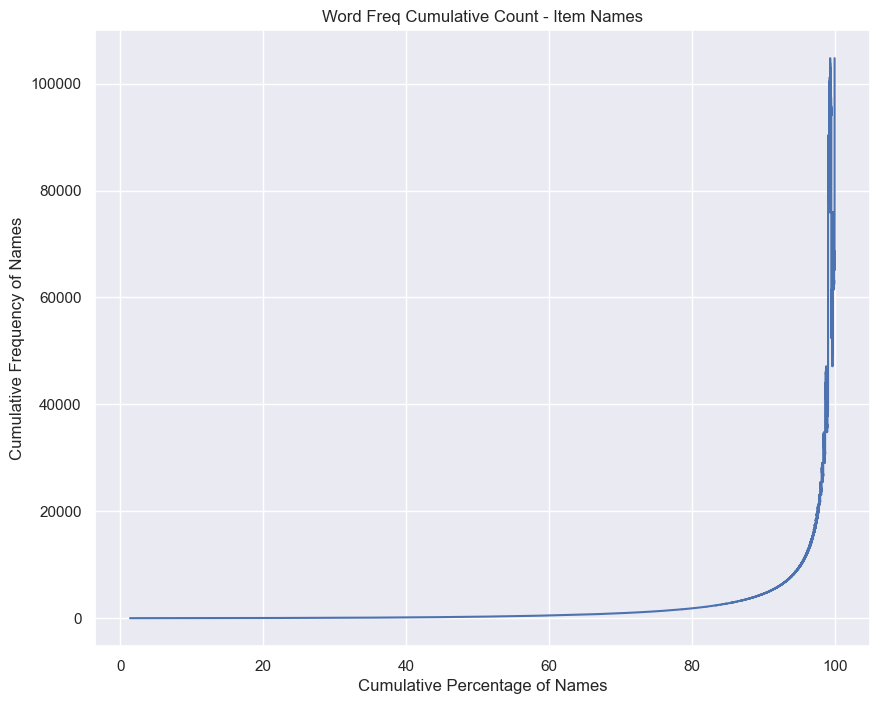

In [46]:
plt.plot(df_names_freq_dist["cumsum_perc"], df_names_freq_dist["index"])
plt.xlabel("Cumulative Percentage of Names")
plt.ylabel("Cumulative Frequency of Names")
plt.title("Word Freq Cumulative Count - Item Names")
plt.show()

As we can see above, Top 20.000 words account for ~95% of total word vocabulary in the Entire Corpus.

In [47]:
t = 95
df_sub = df_names_freq_dist[df_names_freq_dist["cumsum_perc"] < t]
print(len(df_sub), " words out of", len(df_names_freq_dist), " words", 
    " have Cumulative frequency < ",str(t)," and min word freq is ",min(df_sub.Frequency))

9453  words out of 104758  words  have Cumulative frequency <  95  and min word freq is  33


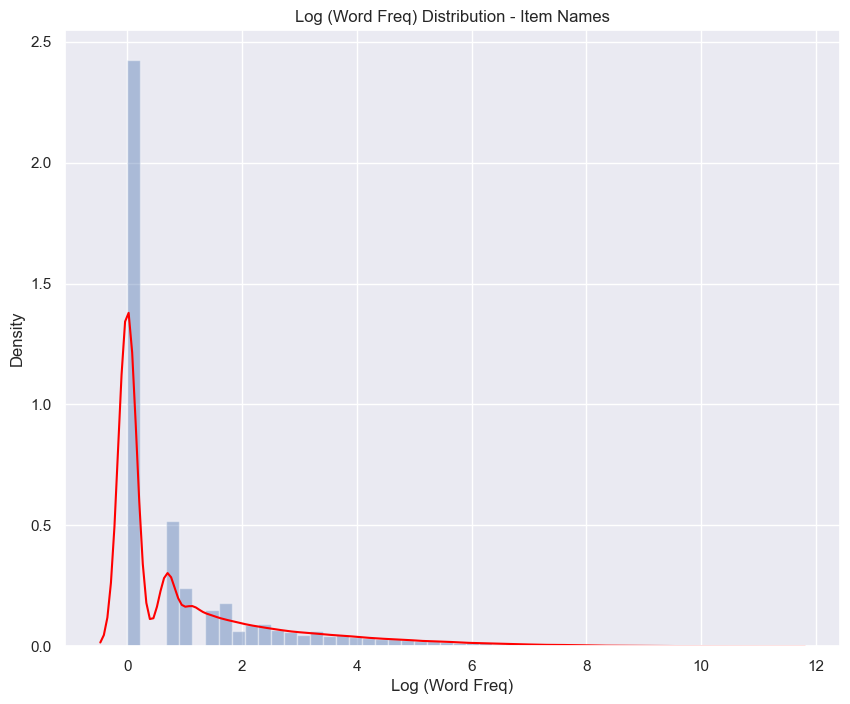

In [48]:
sns.distplot(np.log(df_names_freq_dist["Frequency"]), kde=True, hist=True, kde_kws={"color": "red"})
plt.xlabel("Log (Word Freq)")
plt.title("Log (Word Freq) Distribution - Item Names")
plt.show()

Most words have Log(word frequency) between 0-1

In [49]:
df_names_freq_dist['Frequency'].describe()

count    104758.000000
mean         59.548865
std         880.813042
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       83951.000000
Name: Frequency, dtype: float64

## 2.8 EDA - Visualize "Item Descriptions"

In [50]:
print("Missing values in listing 'Description' are ", df_train.item_description.isnull().sum())

Missing values in listing 'Description' are  4


In [51]:
# replaces missing values and 'No Description Yet' with an empty string
df_train["item_description"] = df_train["item_description"].replace([np.nan,'No description yet'], '')
print("Missing values in listing 'Description' are ", df_train.item_description.isnull().sum())

Missing values in listing 'Description' are  0


In [52]:
df_train["desc_preprocessed"] = text_preprocess(df_train["item_description"])

  0%|          | 0/1482535 [00:00<?, ?it/s]

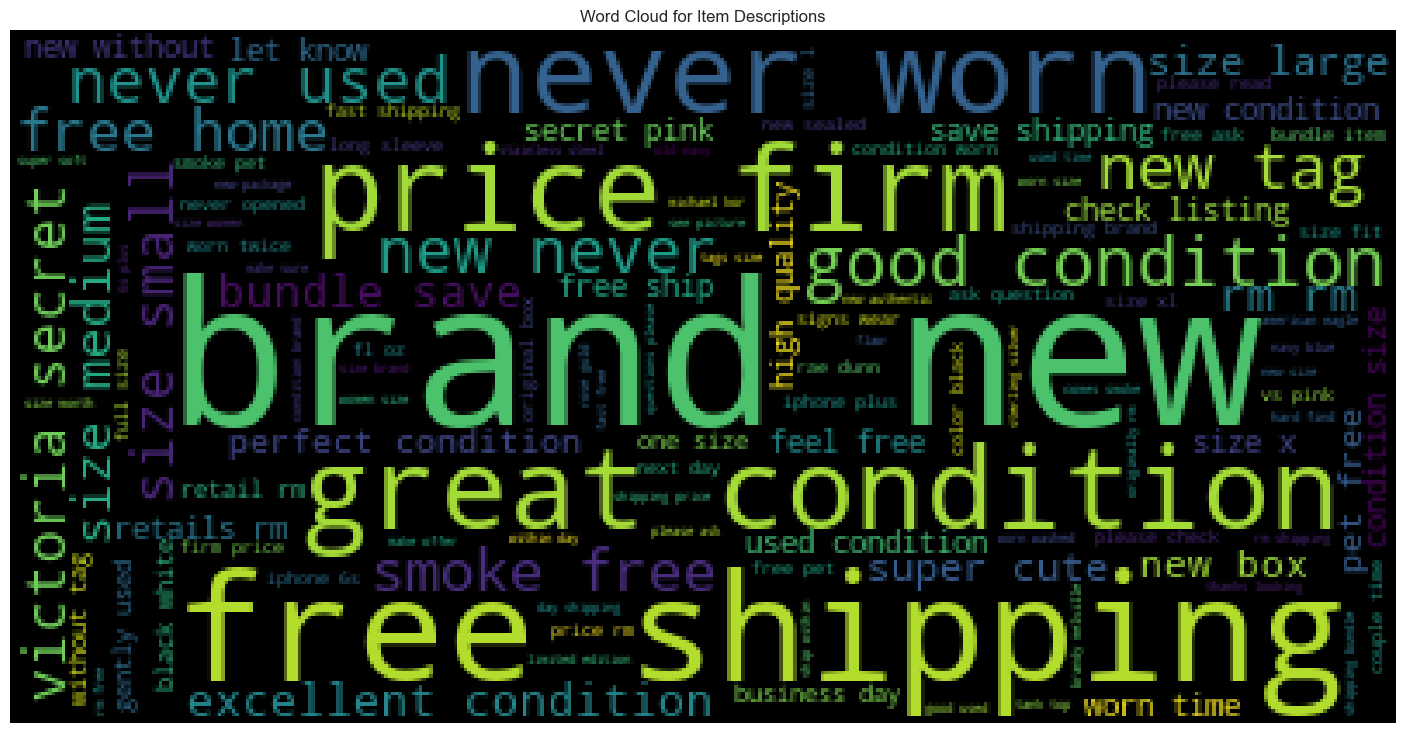

In [53]:
wordcloud = WordCloud(collocations=True).generate(" ".join(df_train.desc_preprocessed.astype(str)))
plt.figure(figsize = (20, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for Item Descriptions")
plt.show()

We can infer that most of these words are talking about the Item Condition which makes sense because this would heavily account for the product prices.

From the above wordcloud (brand,new,free,shipping,description,yet) are the most common words in the item description.

Sellers are using "brand new" , "free shipping" , "price firm", "never worn",...description words to advertise their products to the buyers.

In [54]:
a = df_train["desc_preprocessed"].str.lower().str.cat(sep=" ")
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

df_names_freq_dist = pd.DataFrame(word_dist.most_common(),columns=['Word', 'Frequency'])
df_names_freq_dist = df_names_freq_dist.sort_values(by=['Frequency'],ascending = False)
df_names_freq_dist['cumsum_Frequency'] = df_names_freq_dist['Frequency'].cumsum()
df_names_freq_dist['cumsum_perc'] = round(100*(df_names_freq_dist['cumsum_Frequency']/df_names_freq_dist['Frequency'].sum()),2)
df_names_freq_dist = df_names_freq_dist.reset_index()
print(df_names_freq_dist.shape, ' df_names_freq_dist.shape ')
df_names_freq_dist.head(10)

(160322, 5)  df_names_freq_dist.shape 


,index,Word,Frequency,cumsum_Frequency,cumsum_perc
0,0,new,499710,499710,1.85
1,1,size,456232,955942,3.53
2,2,brand,274497,1230439,4.55
3,3,free,271228,1501667,5.55
4,4,condition,256095,1757762,6.50
5,5,no,244353,2002115,7.40
6,6,not,240553,2242668,8.29
7,7,shipping,227054,2469722,9.13
8,8,rm,225063,2694785,9.96
9,9,2,190782,2885567,10.67


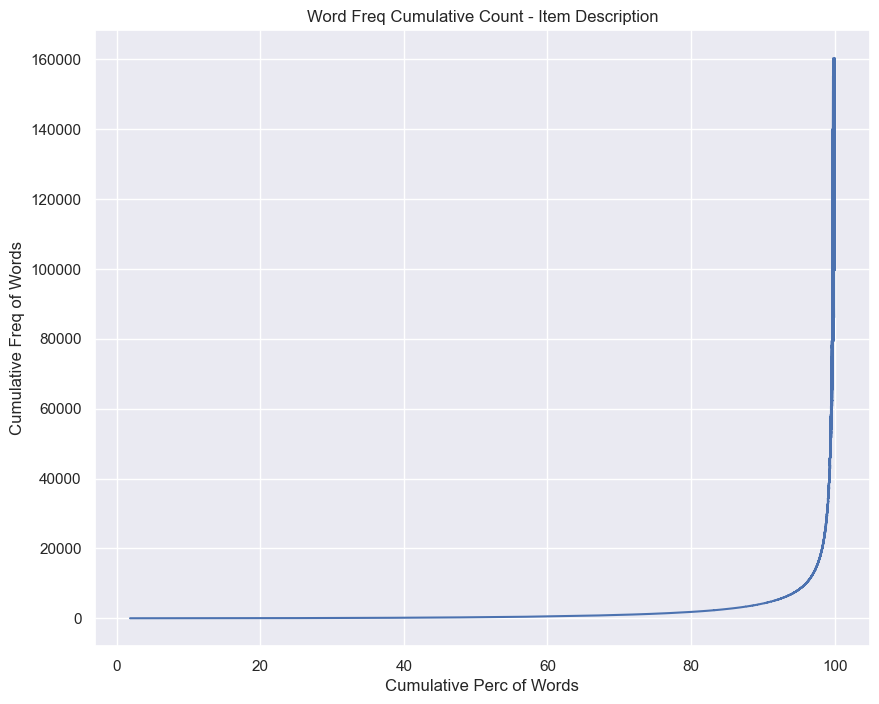

In [55]:
plt.plot(df_names_freq_dist["cumsum_perc"], df_names_freq_dist["index"])
plt.xlabel("Cumulative Perc of Words")
plt.ylabel("Cumulative Freq of Words")
plt.title("Word Freq Cumulative Count - Item Description")
plt.show()

Around top 20.000 words have 98% word coverage in the corpus

In [56]:
t = 98
df_sub = df_names_freq_dist[df_names_freq_dist['cumsum_perc'] < t]
print(len(df_sub)," words out of", len(df_names_freq_dist)," words", 
    " have Cumulative frequency < ",str(t)," and min word freq is ",min(df_sub.Frequency))

17771  words out of 160322  words  have Cumulative frequency <  98  and min word freq is  38


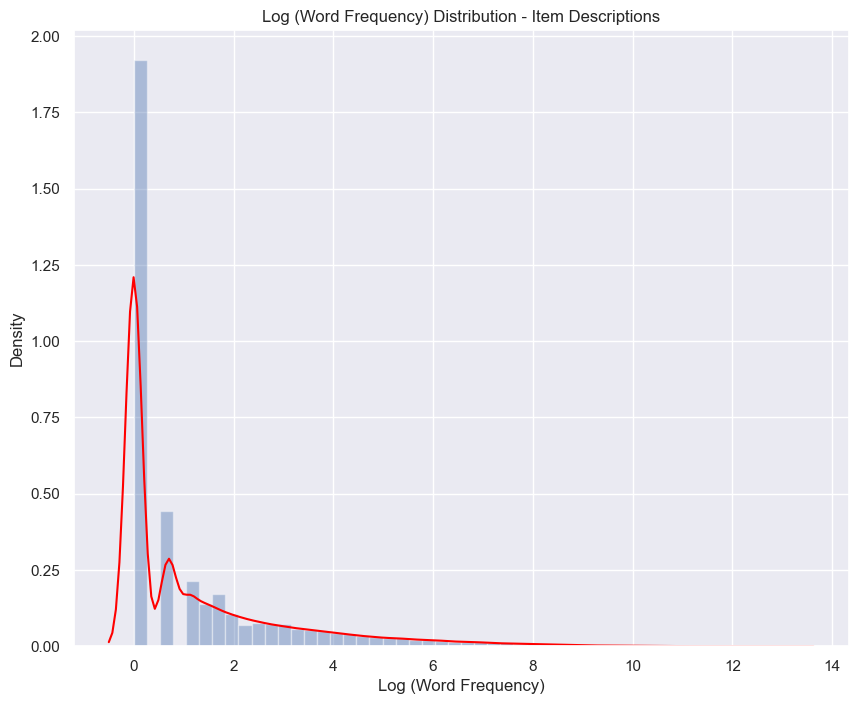

In [57]:
sns.distplot(np.log(df_names_freq_dist['Frequency']),kde = True, hist = True,kde_kws={"color": "red"})
plt.xlabel('Log (Word Frequency)')
plt.title('Log (Word Frequency) Distribution - Item Descriptions')
plt.show()

Most words have Log(Freq) < 2

In [58]:
df_names_freq_dist['Frequency'].describe()

count    160322.000000
mean        168.684323
std        3243.772692
min           1.000000
25%           1.000000
50%           1.000000
75%           6.000000
max      499710.000000
Name: Frequency, dtype: float64

In [68]:
# Calculate description length
df_train['desc_length'] = df_train['item_description'].apply(len)

# Set desc_length to NaN where no description exists
df_train.loc[df_train['item_description'] == 'No description yet', 'desc_length'] = pd.NA

# Compute correlation between desc_length and price
correlation = df_train['desc_length'].corr(df_train['price'], method='pearson', min_periods=1)
print(correlation)


0.04854632836222716


: 

There is no correlation between description length and price.

## 2.9 EDA - Topic Modelling (LDA) on "Item Descriptions"
Below codes performs Topic Modelling using LDA algorithm on Item Descriptions. 
This basically is an unsupervised algorithm which clusters text sentences/words 
into relevant topics that the sentences are talking about.

In [59]:
def lemmatize_stemming(text):
    stemmer  = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def tokenize(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

In [60]:
tqdm.pandas()
df_train['desc_tokenize'] = df_train['desc_preprocessed'].progress_map(tokenize)

100%|██████████| 1482535/1482535 [24:49<00:00, 994.99it/s] 


In [61]:
nltk.download('wordnet')
dictionary = gensim.corpora.Dictionary(df_train['desc_tokenize'].values)
dictionary.filter_extremes(no_below = 50, no_above=0.8, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in df_train['desc_tokenize'].values]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nghaphg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [62]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic {}: Word {}: '.format(idx, topic),'\n')

Topic 0: Word 0.139*"new" + 0.104*"brand" + 0.053*"tag" + 0.050*"box" + 0.031*"rm" + 0.030*"price" + 0.028*"firm" + 0.025*"authent" + 0.022*"open" + 0.021*"retail":  

Topic 1: Word 0.034*"lularo" + 0.030*"leg" + 0.028*"nwt" + 0.018*"bnwt" + 0.016*"black" + 0.016*"os" + 0.015*"tc" + 0.015*"wear" + 0.014*"blue" + 0.014*"wash":  

Topic 2: Word 0.030*"nike" + 0.028*"women" + 0.028*"size" + 0.027*"shoe" + 0.026*"men" + 0.015*"wear" + 0.013*"pair" + 0.013*"condit" + 0.013*"jordan" + 0.012*"toddler":  

Topic 3: Word 0.015*"doll" + 0.010*"set" + 0.010*"outfit" + 0.010*"dvd" + 0.010*"figur" + 0.010*"piec" + 0.009*"star" + 0.007*"jersey" + 0.007*"disney" + 0.007*"new":  

Topic 4: Word 0.040*"oz" + 0.017*"fl" + 0.017*"bottl" + 0.017*"bodi" + 0.015*"ml" + 0.012*"skin" + 0.011*"perfum" + 0.011*"lotion" + 0.010*"bath" + 0.010*"spray":  

Topic 5: Word 0.015*"nwot" + 0.012*"nail" + 0.010*"sunglass" + 0.009*"sheet" + 0.009*"ray" + 0.009*"frame" + 0.009*"mailer" + 0.007*"glass" + 0.007*"polish" + 0

As we can see above, We are printing top 20 Topics that we obtained. 

'Topic 2' is mostly talking about Jewellery Items - words include (necklace,chain,gold,bracelet).

'Topic ' is mostly talking about Accessories - words include (wallet,leather,bag,strap) etc.

'Topic 14' is talking about hair & skin products - words include (hair,oil,skin,nail) etc.

Now that we have a fair bit of Idea about what our data is about, we can proceed with Modelling in the next sections.